100%|██████████| 170M/170M [00:01<00:00, 92.8MB/s]



Training with 10% labeled data...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]



Training with 25% labeled data...

Training with 50% labeled data...
+----------------------------------------------------------+
|                 UKSSL Performance Table                  |
+---------------+----------+-----------+--------+----------+
| Labeled Ratio | Accuracy | Precision | Recall | F1-score |
+---------------+----------+-----------+--------+----------+
|      10%      |  69.28%  |   70.74%  | 69.28% |  68.84%  |
|      25%      |  77.97%  |   78.18%  | 77.97% |  77.79%  |
|      50%      |  82.08%  |   82.51%  | 82.08% |  82.11%  |
+---------------+----------+-----------+--------+----------+


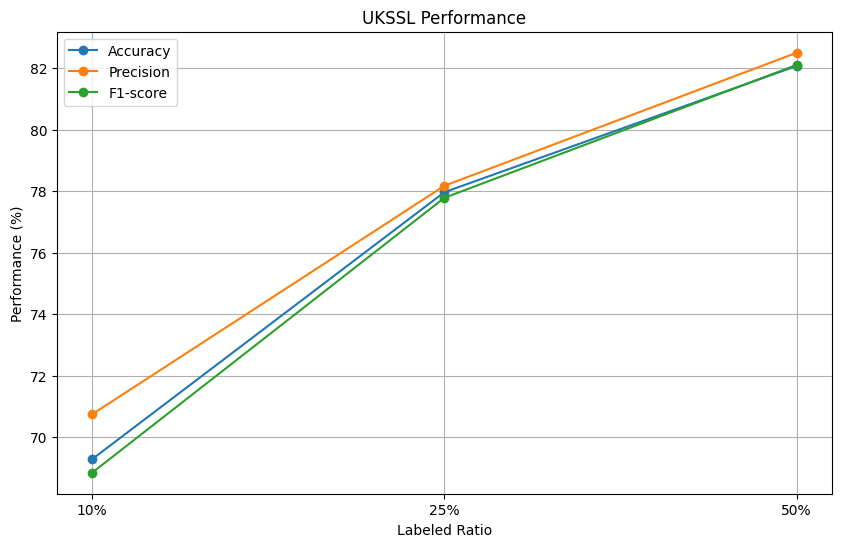

In [ ]:
# UKSSL
import torch, torchvision, numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from prettytable import PrettyTable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets
BCCD = "/content/drive/MyDrive/BCCD_Dataset-master/content/drive/MyDrive/BCCD_Dataset-master"
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

# Label ratios to evaluate
label_ratios = [0.1, 0.25, 0.5]
results = {"Ratio": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []}

def get_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model.to(device)

def train(model, loader, epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate(model):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro') * 100
    recall = recall_score(all_labels, all_preds, average='macro') * 100
    f1 = f1_score(all_labels, all_preds, average='macro') * 100
    return acc, precision, recall, f1

for ratio in label_ratios:
    print(f"\nTraining with {int(ratio*100)}% labeled data...")
    n_total = len(trainset_full)
    n_labeled = int(n_total * ratio)
    indices = np.random.permutation(n_total)
    labeled_indices = indices[:n_labeled]
    labeled_subset = Subset(trainset_full, labeled_indices)
    labeled_loader = DataLoader(labeled_subset, batch_size=128, shuffle=True)

    model = get_model()
    train(model, labeled_loader, epochs=15 if ratio < 0.5 else 20)
    acc, precision, recall, f1 = evaluate(model)

    results["Ratio"].append(f"{int(ratio*100)}%")
    results["Accuracy"].append(acc)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1"].append(f1)

# Display Table
table = PrettyTable()
table.title = "UKSSL Performance Table"
table.field_names = ["Labeled Ratio", "Accuracy", "Precision", "Recall", "F1-score"]
for i in range(len(label_ratios)):
    table.add_row([
        results["Ratio"][i],
        f"{results['Accuracy'][i]:.2f}%",
        f"{results['Precision'][i]:.2f}%",
        f"{results['Recall'][i]:.2f}%",
        f"{results['F1'][i]:.2f}%"
    ])
print(table)

# Plotting
plt.figure(figsize=(10,6))
x = results["Ratio"]
plt.plot(x, results["Accuracy"], label="Accuracy", marker='o')
plt.plot(x, results["Precision"], label="Precision", marker='o')
plt.plot(x, results["F1"], label="F1-score", marker='o')
plt.xlabel("Labeled Ratio")
plt.ylabel("Performance (%)")
plt.title("UKSSL Performance")
plt.legend()
plt.grid(True)
plt.show()
